# Collapse and Grassmannian plots (16x16 MNIST)


This notebook has the following structure:

1. Loads the log file from the 16x16 MNIST experiments, including pairwise similarities and Grassmannian metrics
2. Plots the pairwise similarity matrices for subsequent masks and Hessian subspaces
3. Plots the Grassmannian metrics

In [1]:
import collections
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import pickle

from tueplots import bundles, figsizes

In [2]:
# Seaborn setup
sns.set_theme(style="white")
colors = sns.color_palette()

## Prepare Data

In [4]:
DATA_DIR = "../output_analysis/further_tinymnist_analysis/output_analysis"


def load_data(DATA_DIR):
    file_paths = [os.path.join(DATA_DIR, p) for p in os.listdir(DATA_DIR)]

    scalar_path = [p for p in file_paths if "compute_scalars" in p][0]
    with open(scalar_path, "rb") as f:
        scalar_data = pickle.load(f)

    matrix_paths = [p for p in file_paths if "compute_matrices" in p]
    matrices = []
    for mp in matrix_paths:
        f = open(mp, "rb")
        matrices.append(pickle.load(f))
        f.close()

    sparsities = sorted(matrices[0]["config"]["SPARSITIES"])
    row_indices = [m["config"]["ROW_INDEX"] for m in matrices]
    col_indices = [m["config"]["COL_INDICES"] for m in matrices]
    mat_len = max(row_indices) + 1

    dense_matrices = [[np.eye(mat_len) for _ in sparsities] for _ in range(3)]

    for m, row, cols in zip(matrices, row_indices, col_indices):
        for sp_i, sp in enumerate(sparsities):
            dense_matrices[0][sp_i][row, cols] = m["param_iou"][sp]
            dense_matrices[0][sp_i][cols, row] = m["param_iou"][sp]
            #
            dense_matrices[1][sp_i][row, cols] = m["train_overlap"][sp]
            dense_matrices[1][sp_i][cols, row] = m["train_overlap"][sp]
            #
            dense_matrices[2][sp_i][row, cols] = m["test_overlap"][sp]
            dense_matrices[2][sp_i][cols, row] = m["test_overlap"][sp]

    return scalar_data, dense_matrices


scalar_data, matrices = load_data(DATA_DIR)

In [5]:
for metric in [
        "geodesic", "chord2", "chordF", "proj2", "projF", "fubini", "overlap"
]:
    for split in ["train", "test"]:
        unprocessed_metric = scalar_data[metric + "_" + split]
        if metric == "overlap":
            scalar_data["metric_" + metric + "_" + split] = {
                k: np.array(v)
                for k, v in unprocessed_metric.items()
            }
        else:
            scalar_data["metric_" + metric + "_" + split] = {
                k: 1 - np.array(v)
                for k, v in unprocessed_metric.items()
            }

## Plot

### Stabilization (IoU & Overlap Heatmaps)

In [6]:
ncols = 4
nrows = 3
ratio = 0.9

# TUEplots
plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams.update(
    figsizes.icml2022_full(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=ratio,
    ),
)
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.01})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.01})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})

In [7]:
def plot_heatmap(ax, data, scalar_data, row, col):
    sparsity = col
    subspace = row
    map_sparsity_index = {
        0: 0.005,
        1: 0.01,
        2: 0.05,
        3: 0.2,
    }
    matrix = data[subspace][sparsity]

    # Compute max steps
    max_steps = scalar_data["steps"][len(matrix)]

    # Plot the matrix
    im = ax.imshow(matrix,
                   vmin=0,
                   vmax=1,
                   cmap="cividis",
                   extent=[0, max_steps, max_steps, 0])

    # Polish
    if row == 0:
        ax.set_title(
            rf"\textbf{{Sparsity Ratio}} $\mathbf{{\rho={map_sparsity_index[sparsity]}}}$"
        )
    if col == 0:
        if row == 0:
            ax.set_ylabel(r"\textbf{Parameter Mask IoU}")
        elif row == 1:
            ax.set_ylabel(r"$\mathbf{overlap}$ ($\mathbf{H}_{train}$)")
        elif row == 2:
            ax.set_ylabel(r"$\mathbf{overlap}$ ($\mathbf{H}_{test}$)")
    # if row == 2:
    #     ax.set_xlabel("Training Iteration")
    if col == 3:
        cbar = plt.colorbar(im, fraction=0.05, pad=0.04)
        cbar.ax.tick_params(size=0, pad=5)
        cbar.outline.set_linewidth(0.5)

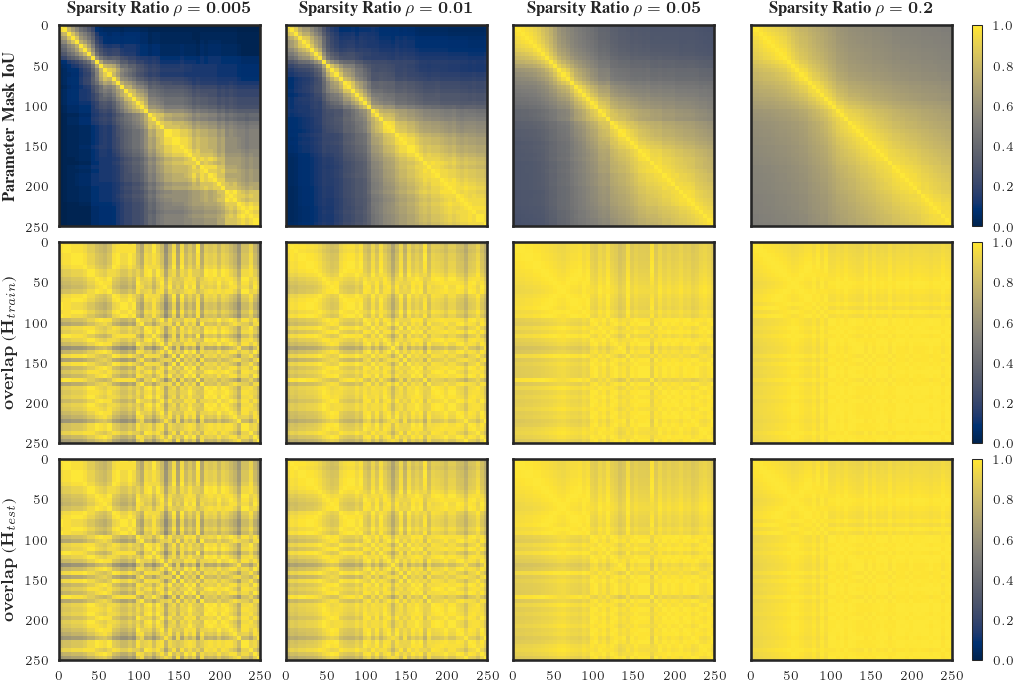

In [8]:
fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True)

for row, axs_row in enumerate(axs):
    for col, ax in enumerate(axs_row):
        plot_heatmap(ax, matrices, scalar_data, row, col)

# Save and show
plt.savefig("plot_output/stabilization.pdf")
plt.show()

### Comparing Grassmannian Metrics on MNIST

In [9]:
ncols = 1
nrows = 8
ratio = 0.12

# TUEplots
plt.rcParams.update(bundles.icml2022(column="full"))
plt.rcParams.update(
    figsizes.icml2022_full(
        nrows=nrows,
        ncols=ncols,
        height_to_width_ratio=ratio,
    ),
)
plt.rcParams.update({"figure.constrained_layout.h_pad": 0.01})
plt.rcParams.update({"figure.constrained_layout.w_pad": 0.01})
plt.rcParams.update({"xtick.major.pad": -1})
plt.rcParams.update({"ytick.major.pad": -1})
plt.rcParams.update({"figure.dpi": 150})

In [10]:
def plot_scalar(ax, data, property, steps, label, show_legend=False):
    y = data[property]
    if len(y) == 4:
        for sparsity in [0.2, 0.05, 0.01, 0.005]:
            ax.plot(steps, y[sparsity], label=rf"$\rho={sparsity}$")
    else:
        ax.plot(steps, y, label=property)

    # Monkeypatch baselines:
    if property == "metric_geodesic_train":
        baseline = 1 - 0.75466
    elif property == "metric_chord2_train":
        baseline = 1 - 0.99954
    elif property == "metric_chordF_train":
        baseline = 1 - 0.78246
    elif property == "metric_proj2_train":
        baseline = 1 - 1.00000
    elif property == "metric_projF_train":
        baseline = 1 - 0.89430
    elif property == "metric_fubini_train":
        baseline = 1 - 1.00000
    elif property == "metric_overlap_train":
        baseline = 0.2
    else:
        baseline = None
    
    if baseline is not None:
        ax.axhline(y=baseline, color=colors[0], linestyle="--", zorder=0, alpha=0.75)

    # Polish
    ax.set_xlim([0, 1000])
    ax.set_ylabel(rf"\textbf{{{label}}}")
    if label != "Batch Loss":
        ax.set_ylim([0, 1])
    if show_legend:
        ax.legend()

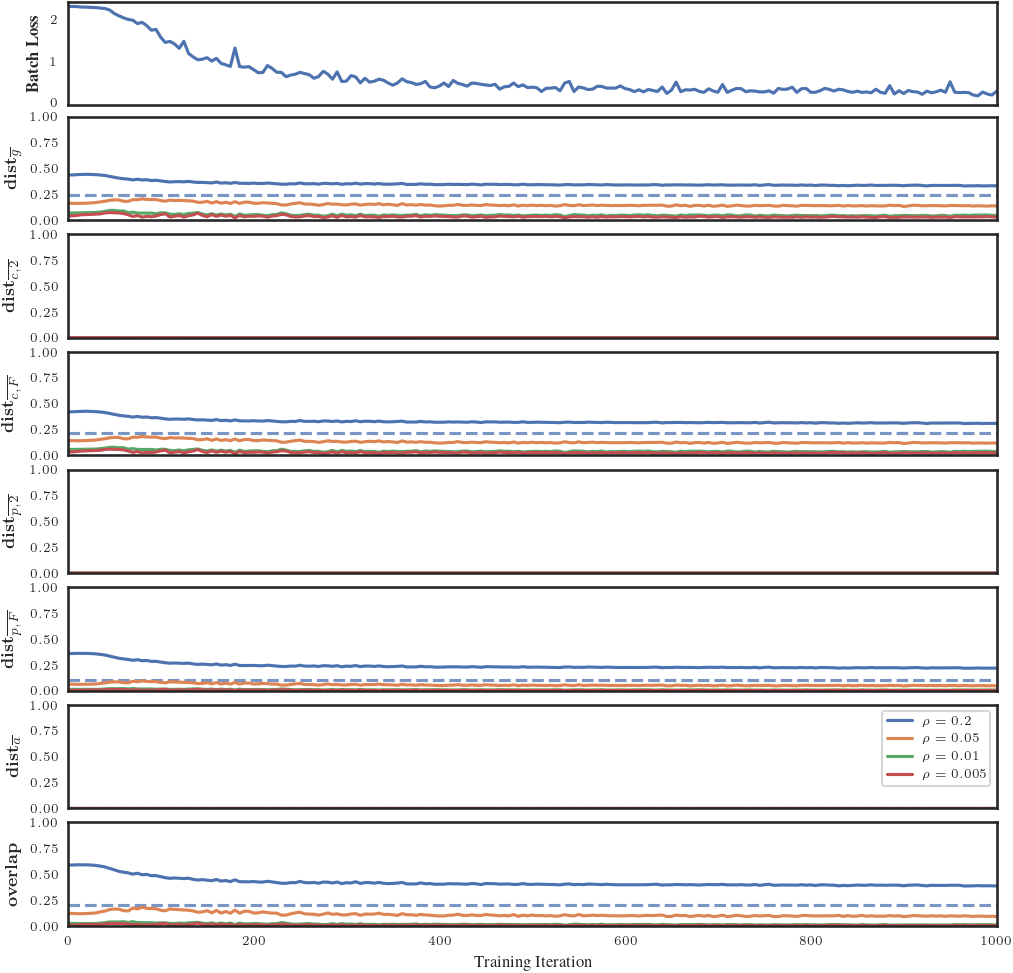

In [11]:
fig, axs = plt.subplots(nrows, ncols, sharex=True)

plot_scalar(
    axs[0], scalar_data, "batch_loss", steps=scalar_data["steps"], label="Batch Loss"
)
# Accuracy
plot_scalar(
    axs[1],
    scalar_data,
    "metric_geodesic_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{dist}_{\overline{g}}$",
)
plot_scalar(
    axs[2],
    scalar_data,
    "metric_chord2_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{dist}_{\overline{c,2}}$",
)
plot_scalar(
    axs[3],
    scalar_data,
    "metric_chordF_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{dist}_{\overline{c,F}}$",
)
plot_scalar(
    axs[4],
    scalar_data,
    "metric_proj2_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{dist}_{\overline{p,2}}$",
)
plot_scalar(
    axs[5],
    scalar_data,
    "metric_projF_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{dist}_{\overline{p,F}}$",
)
plot_scalar(
    axs[6],
    scalar_data,
    "metric_fubini_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{dist}_{\overline{a}}$",
    show_legend=True,
)
plot_scalar(
    axs[7],
    scalar_data,
    "metric_overlap_train",
    steps=scalar_data["steps"],
    label=r"$\mathbf{overlap}$",
)

axs[7].set_xlabel("Training Iteration")

# Save and show
plt.savefig("plot_output/grassmannians.pdf")
plt.show()